In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv
/kaggle/input/predict-student-performance-from-game-play/train_labels.csv
/kaggle/input/predict-student-performance-from-game-play/train.csv
/kaggle/input/predict-student-performance-from-game-play/test.csv
/kaggle/input/predict-student-performance-from-game-play/jo_wilder_310/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder_310/__init__.py
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/__init__.py


# **Loading the dataset**

Since the dataset is huge, some people may face memory errors while reading the dataset from the csv. To avoid this, we will try to optimize the memory used by Pandas to load and store the dataset.

When Pandas loads a dataset, by default, it automatically detects the data types of the different columns. Irresepective of the maximum value that is stored in these columns, Pandas assigns int64 for numerical columns, float64 for float columns, object dtype for string columns etc.

We may be able to reduce the size of these columns in memory by downcasting numerical columns to smaller types (like int8, int32, float32 etc.), if their maximum values don't need the larger types for storage, (like int64, float64 etc.).

Similarly, Pandas automatically detects string columns as object datatype. To reduce memory usage of string columns which store categorical data, we specify their datatype as category.

Many of the columns in this dataset can be downcast to smaller types.

We will provide a dict of dtypes for columns to pandas while reading the dataset.

Ref: https://www.kaggle.com/code/gusthema/student-performance-w-tensorflow-decision-forests

In [2]:
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}

df_train_text = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', dtype=dtypes)
df_test_text = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/test.csv', dtype=dtypes)

# **Loading the labeled dataset**

In [3]:
df_train_labels = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')

In [4]:
df_train_labels[['Session_ID_labels', 'question']] =  df_train_labels['session_id'].str.split('_',expand=True)


# Exploring the dataset, i.e., train and test

In [5]:
class exploreData():
    
    def __init__(self, train, test):
        self.train = train
        self.test = test
       
    def trainHead(self):
        return self.train.head()
    
    def testHead(self):
        return self.test.head()
    
    def trainDataset_description(self):
        return self.train.describe()
    
    def testDataset_description(self):
        return self.test.describe()
    
    def column_info(self):
        
        print('''We will be underdtading the basic structure of the dataset that we have. This includes general information like:
        
            * Column data types
            
            ''')
        
        print('Columns for the training dataset looks like:')
        train_data = self.train.dtypes
        
        print('\n')
        
        print('Columns for the training dataset looks like:')
        test_data = self.test.dtypes
        
        return train_data, test_data
    

In [6]:
if __name__ == "__main__":
    print("Before going any further, I want to see how the training and testing data looks like:")
    print('\n')
    exploredata = exploreData(df_train_text,df_test_text)
    print("Let's see how the train data looks like:")
    print('\n')
    exploredata.trainHead()
    print(exploredata.trainDataset_description())
    print('\n')
    print("Let's see how our test data looks like:")
    exploredata.testHead()
    print(exploredata.testDataset_description)
    print('\n')
    print(exploredata.column_info())
    

Before going any further, I want to see how the training and testing data looks like:


Let's see how the train data looks like:


         session_id         index  elapsed_time         level           page  \
count  2.629695e+07  2.629695e+07  2.629695e+07  2.629695e+07  564544.000000   
mean   2.113249e+16  6.445102e+02  4.016694e+06  1.219169e+01       3.166559   
std    5.712953e+14  5.457880e+02  3.127032e+07  6.497789e+00       2.063291   
min    2.009031e+16  0.000000e+00  0.000000e+00  0.000000e+00       0.000000   
25%    2.101022e+16  2.880000e+02  4.397000e+05  6.000000e+00       1.000000   
50%    2.104021e+16  5.950000e+02  1.014801e+06  1.300000e+01       3.000000   
75%    2.110052e+16  8.960000e+02  1.747040e+06  1.800000e+01       5.000000   
max    2.210022e+16  2.047300e+04  1.988607e+09  2.200000e+01       6.000000   

        room_coor_x   room_coor_y  screen_coor_x  screen_coor_y  \
count  2.422367e+07  2.422367e+07   2.422367e+07   2.422367e+07   
mean  -5.49058

It looks like we have a lot of unstructured data in the form of "category" and "object" data types. Columns which are unstructured in nature are:

1. text              category
2. fqid              category
3. room_fqid         category
4. text_fqid         category
5. fullscreen        category
6. hq                category
7. music             category
8. level_group       category
9. event_name        category
10. name              category

In [7]:
class trainDataPreparation:
    
    def __init__(self):
        pass

    def merge(self):

        global df_train_final
        df_train_final = pd.concat([df_train_text, df_train_labels], axis = 1, join = 'inner')
        return df_train_final
    
    def checkNA(self):
        
        self.merge()
        
        return df_train_final.isna().sum()
    
    def numberOfRows(self):
        
        number_of_rows = df_train_final.shape[0]
        print('Total number of rows in the dataset:',number_of_rows)
        
        
        
        

In [8]:
print("Let's initiate the above module and the 'merge' method to get the dataset that we want for our exploratory data analysis:")
trainData = trainDataPreparation()
trainData.merge()

Let's initiate the above module and the 'merge' method to get the dataset that we want for our exploratory data analysis:


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,room_fqid,text_fqid,fullscreen,hq,music,level_group,session_id,correct,Session_ID_labels,question
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,...,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,20090312431273200_q1,1,20090312431273200,q1
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,...,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,20090312433251036_q1,0,20090312433251036,q1
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,...,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,20090312455206810_q1,1,20090312455206810,q1
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,...,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,20090313091715820_q1,0,20090313091715820,q1
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,...,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,20090313571836404_q1,1,20090313571836404,q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424111,20100209055089116,749,1783642,navigate_click,undefined,14,NaN,-818.776672,-205.816818,645.0,...,tunic.historicalsociety.cage,NaN,0,0,1,13-22,22100215342220508_q18,1,22100215342220508,q18
424112,20100209055089116,750,1784840,navigate_click,undefined,14,NaN,-583.063293,-104.244759,725.0,...,tunic.historicalsociety.cage,NaN,0,0,1,13-22,22100215460321130_q18,1,22100215460321130,q18
424113,20100209055089116,751,1785573,navigate_click,undefined,14,NaN,-367.956482,-184.003281,792.0,...,tunic.historicalsociety.cage,NaN,0,0,1,13-22,22100217104993650_q18,1,22100217104993650,q18
424114,20100209055089116,752,1786655,navigate_click,undefined,14,NaN,-74.807930,-188.108093,802.0,...,tunic.historicalsociety.cage,NaN,0,0,1,13-22,22100219442786200_q18,1,22100219442786200,q18


The above class is a helper module which will be helpful for us in future to merge the text and their corresponding labels. It will also help us in letting us know the following details:

1. NA values in the dataset
2. number of rows in the dataset

**According to the data, not all of the events have fully qualified ID. 
But since this project is about the events the children are enrolled in, I first need to see how many events are there.**

To explore the data regarding events, we need to consider the following features:

1. event_name
2. fqid
3. room_fqid
4. session_id
5. question

Also we will be assessing various factors as to what happens if the moderator is asking a question to the player. We will try to understand the mentality of the student. Is he/she on later stages of the questions, on what level i=does the moderator needs to intervene and is the player hovering or clicking

Then finally, after understanding the player mentality, now we will understand a couple of basic things:

Monitor the student performance based on the number of pages in the games?

1. Level group/ # of pages
2. If hover time is less, then number of pages is less?

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

class level_group_studentActivity:
    
    def __init__(self):
        self.df_train = df_train_text
        
    def levelForAges(self):
        level_and_ages = pd.DataFrame({
                "level": self.df_train['level'],
                "page": self.df_train['page']
            })
        
        level_and_ages_final  = level_and_ages.dropna()
        print(level_and_ages_final.groupby('level').first())
        print('\n')
        return level_and_ages_final.groupby('level').first().plot()

class event(level_group_studentActivity):
    
    def __init__(self):
        self.df_train = df_train_final
        
    def eventName(self):
        return self.df_train['event_name'].value_counts()
    
    def eventName_ID(self):
        return pd.pivot_table(data=self.df_train,index=['event_name'])
    
    def event_activity_fqid(self):
        
        global df_hovering
        
        df_activity_info = self.df_train[['event_name', 'fqid', 'room_fqid', 'correct', 'question','fullscreen']]
        max_correct = max(df_activity_info['correct'])
        ## total number of questions
        print('\n')
        print('Total number of questions per event:')
        print(df_activity_info['question'].value_counts())
        print("\n")
        #df_activity_info.groupby('question').size().plot(kind='pie', autopct='%.2f')
        print(pd.pivot_table(data = df_activity_info,index = 'event_name'))
        print('\n')
        print("Activity based on hovering of mouse:")
        print('\n')
        df_hovering = df_activity_info.loc[df_activity_info['correct'] == max_correct]
        df_hovering[['event_in_the_game','event_name_click']] = df_hovering['event_name'].str.split('_',expand=True)
        print(df_hovering['event_name_click'].value_counts())
        df_hovering[['room_fquid_0','room_fquid_1','room_fquid_2']] = df_hovering['room_fqid'].str.split('.',expand=True)
        
    def event_activity_room_fqid(self):
        print(df_hovering['room_fquid_2'].value_counts())    
        return df_hovering.groupby('room_fquid_2').size().plot(kind='bar')
        
    def event_inTheGame_max(self):
        print(df_hovering['event_in_the_game'].value_counts())
        return df_hovering.groupby('event_in_the_game').size().plot(kind='bar')
    
    def navigateRoomfqid(self):
        return df_hovering.groupby('question').size().plot(kind='bar')
    
    def fullscreen_mode(self):
        
        return df_hovering['fullscreen'].value_counts().plot()
    
class textEDA:
    
    def __init__(self):
        self.df_train = df_train_final
        
    def prepareQuestionMarkdata(self):
        global df_questionMark
        self.df_train['QuestionMark_present'] = self.df_train['text'].str.endswith('?')
        df_questionMark=self.df_train.loc[self.df_train['QuestionMark_present'] == True]
        df_questionMark[['event_in_the_game','edf_questionMark']] = df_questionMark['event_name'].str.split('_',expand=True)
        df_questionMark[['room_fquid_0','room_fquid_1','room_fquid_2']] = df_questionMark['room_fqid'].str.split('.',expand=True)
        return df_questionMark
    
    def timeSpentinRoom(self):
        plt.figure(figsize=(12,5))
        print('\n')
        print(df_questionMark['room_fquid_2'].value_counts())
        print('\n')
        index = list(df_questionMark['room_fquid_2'].value_counts().index)
        values = list(df_questionMark['room_fquid_2'].value_counts().values)
        plt.title("Player spent most time when a promt was given to them as a question")
        
        return plt.plot(index,values)
    
    def whichLevel(self):
        plt.figure(figsize=(12,5))
        print('\n')
        print(df_questionMark['level'].value_counts())
        print('\n')
        index = list(df_questionMark['level'].value_counts().index)
        values = list(df_questionMark['level'].value_counts().values)
        plt.title("On what level was the player in when the moderator asked them a question")
        
        return plt.plot(index,values)
     
    def difficultQuestion(self):
     
        plt.figure(figsize=(12,5))
        print('\n')
        print(df_questionMark['question'].value_counts())
        print('\n')
        index = list(df_questionMark['question'].value_counts().index)
        values = list(df_questionMark['question'].value_counts().values)
        plt.title("On what level was the player in when the moderator asked them a question")
        
        return plt.plot(index,values)
    
    def what_eventIntheGame(self):
     
        plt.figure(figsize=(12,5))
        print('\n')
        print(df_questionMark['event_in_the_game'].value_counts())
        print('\n')
        index = list(df_questionMark['event_in_the_game'].value_counts().index)
        values = list(df_questionMark['event_in_the_game'].value_counts().values)
        plt.title("What is the event in the Game")
        
        return plt.plot(index,values)
    
    def what_playerIsDoing(self):
        plt.figure(figsize=(12,5))
        print('\n')
        print(df_questionMark['edf_questionMark'].value_counts())
        print('\n')
        index = list(df_questionMark['edf_questionMark'].value_counts().index)
        values = list(df_questionMark['edf_questionMark'].value_counts().values)
        plt.title("Is the person clicking or doing something else when question is being asked?")
        
        return plt.plot(index,values)
    
    
    def howMuchTimeelapsed(self):
        df_questionMark['elapsed_time'] = (df_questionMark['elapsed_time']/(1000*60))%60
        print('Elapsed time column converted into minutes')
        print('\n')
        max_timeelapsed = max(df_questionMark['elapsed_time'])
        print('\n')
        df_questionMark_maxTime = df_questionMark.loc[df_questionMark['elapsed_time'] == max_timeelapsed]
        
        print("Details about the situation where maximum time elapsed:")
        print('\n')
        print("Question where maximum time was spent:",df_questionMark_maxTime['question'].item())
        print("What was the event in the game:",df_questionMark_maxTime['event_in_the_game'].item())
        print("Time spent (in minutes):", df_questionMark_maxTime['elapsed_time'].item(),"minutes")
        #print("Session ID where student spent time and the moderator had to ask a question:",df_questionMark_maxTime['session_id'].item())
        print("In what location the player was in the game:", df_questionMark_maxTime['room_fquid_2'].item())
        print("In what level player was in:",df_questionMark_maxTime['level'].item())
        print('\n')
        
        return df_questionMark_maxTime


In [10]:
df_train_text['hover_duration'] = df_train_text['hover_duration']/(1000*60)%60
df_train_text.columns

Index(['session_id', 'index', 'elapsed_time', 'event_name', 'name', 'level',
       'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
       'hover_duration', 'text', 'fqid', 'room_fqid', 'text_fqid',
       'fullscreen', 'hq', 'music', 'level_group'],
      dtype='object')

We will now explore the data:


       page
level      
1       0.0
2       0.0
3       0.0
4       1.0
5       1.0
6       1.0
7       1.0
8       2.0
9       2.0
10      3.0
11      3.0
12      3.0
13      3.0
14      4.0
15      4.0
16      4.0
17      4.0
18      5.0
19      5.0
20      6.0
21      6.0
22      6.0




<AxesSubplot:xlabel='level'>

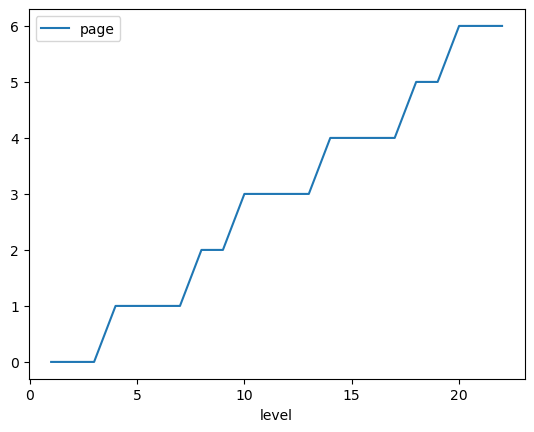

In [11]:
print("We will now explore the data:")
print('\n')
levelsofGame = level_group_studentActivity()
levelsofGame.levelForAges()

from the above information and graph we can see that the number of pages in educational games and learning is increasing linearly in a positive trend. This means that as the level increases, the number of pages that the student needs to encounter are also increasing.

we can assume from the above information that the learning curve increases steeply as the level increases

In [12]:
print("Let's explore all the events present in the data:")
print("\n")
Events = event()
print("Events present in the game are:")
print("\n")
print(Events.eventName())


Let's explore all the events present in the data:


Events present in the game are:


navigate_click        179177
person_click           97449
cutscene_click         42884
object_click           35890
object_hover           19099
map_hover              17316
notification_click     10328
notebook_click          8712
map_click               8555
observation_click       3557
checkpoint              1149
Name: event_name, dtype: int64


So the maximum number of events in the game are coming from the clicking of buttons/toggle bar while navigating while the student is saving his work through checkpoint very less. this could either mean that the student is able to finish a lot learning/exercise in a single sitting or he is loosing his/her concentration quickly and exiting the game

In [13]:
Events.eventName_ID()

,correct,elapsed_time,hover_duration,index,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,session_id
event_name,,,,,,,,,,,
checkpoint,0.681462,2.721790e+06,NaN,634.566580,12.642298,NaN,NaN,NaN,NaN,NaN,2.009946e+16
cutscene_click,0.709355,2.373476e+06,NaN,493.005247,10.388070,NaN,-209.836456,-72.994057,418.890137,387.434082,2.009946e+16
map_click,0.702513,2.801367e+06,NaN,717.232145,13.122385,NaN,254.655640,1.415314,514.146423,294.679596,2.009934e+16
map_hover,0.703858,3.191643e+06,465.458893,824.668168,14.799261,NaN,NaN,NaN,NaN,NaN,2.009927e+16
navigate_click,0.704320,2.907814e+06,NaN,704.764741,12.572306,NaN,-94.287643,-145.608780,447.488983,403.272949,2.009937e+16
notebook_click,0.701905,3.834472e+06,NaN,694.187557,12.656910,3.116276,-94.194229,-82.005035,426.861542,354.375397,2.009936e+16
notification_click,0.703912,2.579553e+06,NaN,575.790860,10.838497,NaN,74.396431,-148.160828,497.159119,448.649475,2.009945e+16
object_click,0.700251,2.342438e+06,NaN,632.676205,11.196601,NaN,234.843201,-6.510121,578.060913,325.172729,2.009944e+16
object_hover,0.710247,2.799997e+06,2556.538330,675.715587,12.653752,NaN,NaN,NaN,NaN,NaN,2.009942e+16


From our assumption above, we can see that there is not much elapsed time when the student is at checkpoint and the student is constantly either hovering over the map section or clicking on the map. Hence, the student is getting stucked and is trying to see if he/she is heading towards the right direction or not.

In [14]:
Events.event_activity_fqid()



Total number of questions per event:
q1     23562
q2     23562
q17    23562
q16    23562
q15    23562
q14    23562
q13    23562
q12    23562
q11    23562
q10    23562
q9     23562
q8     23562
q7     23562
q6     23562
q5     23562
q4     23562
q3     23562
q18    23562
Name: question, dtype: int64


                     correct
event_name                  
checkpoint          0.681462
cutscene_click      0.709355
map_click           0.702513
map_hover           0.703858
navigate_click      0.704320
notebook_click      0.701905
notification_click  0.703912
object_click        0.700251
object_hover        0.710247
observation_click   0.717459
person_click        0.708453


Activity based on hovering of mouse:




/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


click    272735
hover     25753
Name: event_name_click, dtype: int64


Following are the observation from the above sequence:

1. There are 18 questions in total and every question has equal number of question.
2. Even if we consider our assumption, a student in educational leaning is spending more time in clicking as compare to hovering which can be considered idling in some cases and not paying attention. hence, we can say that even if the student is finding the activities difficult, the interactivity in these games are making the students engaged in the activity.
3. We also notice that most number of correct answers are coming from clicking on an object.

frontdesk          73101
entry              50590
center             33634
cage               26914
stacks             20895
closet_dirty       17674
hall               13608
basement           13095
halloffame         12602
microfiche         11504
collection         10821
closet              9596
collection_flag     5237
Name: room_fquid_2, dtype: int64


<AxesSubplot:xlabel='room_fquid_2'>

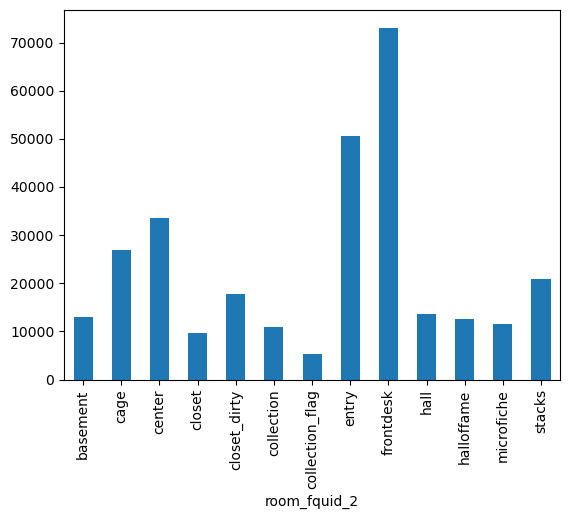

In [15]:
Events.event_activity_room_fqid()

navigate        126198
person           69038
object           38697
cutscene         30420
map              18198
notification      7270
notebook          6115
observation       2552
checkpoint         783
Name: event_in_the_game, dtype: int64


<AxesSubplot:xlabel='event_in_the_game'>

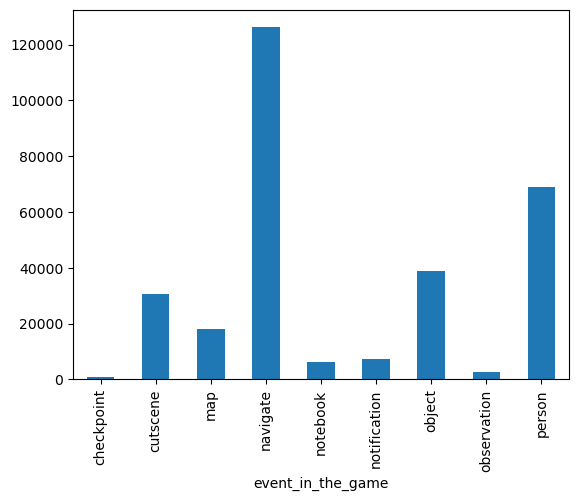

In [16]:
Events.event_inTheGame_max()

<AxesSubplot:>

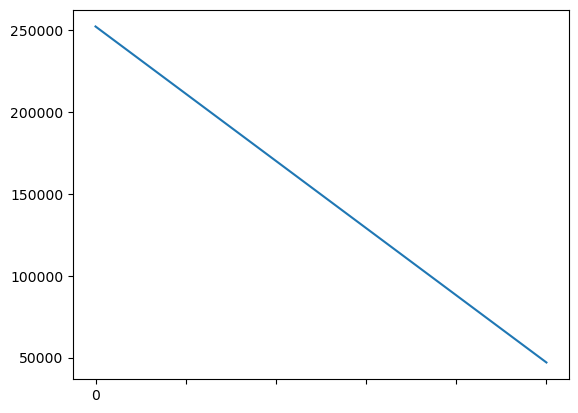

In [17]:
Events.fullscreen_mode()

<AxesSubplot:xlabel='question'>

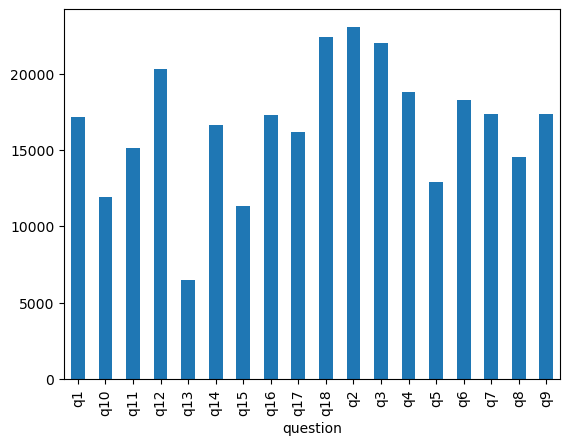

In [18]:
Events.navigateRoomfqid()

All the above graphs and information are extracted where there are maximum number of correct answers. Surprisingly, it was seen that even though the number of pages increases and the student is spending more time on checkpoint as well, but they are also answering correct questions when reached at later stages of the question.

Also, in most of the correct options, the student was not in Fullscreen mode.

And as previously mentioned, a student in the game spends a lot time navigating. Hence, we can say that in order for a student to perform good, the student is navigating no the screen where he/she is on to make an informed decision.

The room where most of the coorect answers were found were in:

1. Frontdesk
2. Entry
3. Center



Let us understand the unstructured part of the data:


Total number of instances where the moderator needed to ask question from the student: 29569
Elapsed time column converted into minutes




Details about the situation where maximum time elapsed:


Question where maximum time was spent: q15
What was the event in the game: cutscene
Time spent (in minutes): 59.9914 minutes
In what location the player was in the game: basement
In what level player was in: 13




q18    1818
q12    1775
q11    1764
q3     1759
q14    1722
q8     1712
q9     1688
q16    1675
q5     1642
q1     1618
q6     1614
q2     1597
q17    1558
q13    1547
q7     1528
q15    1524
q10    1523
q4     1505
Name: question, dtype: int64




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




frontdesk          11872
entry               4707
center              3062
cage                1998
closet_dirty        1934
basement            1922
collection          1870
closet              1243
collection_flag      512
hall                 449
Name: room_fquid_2, dtype: int64




18    5150
6     4259
9     1941
13    1925
2     1872
11    1796
19    1724
8     1698
7     1632
16    1627
10    1170
0     1148
21    1080
1     1053
15     442
17     425
20     378
3      142
5       96
14       6
12       4
22       1
Name: level, dtype: int64




person          23159
cutscene         6149
notification      261
Name: event_in_the_game, dtype: int64




click    29569
Name: edf_questionMark, dtype: int64




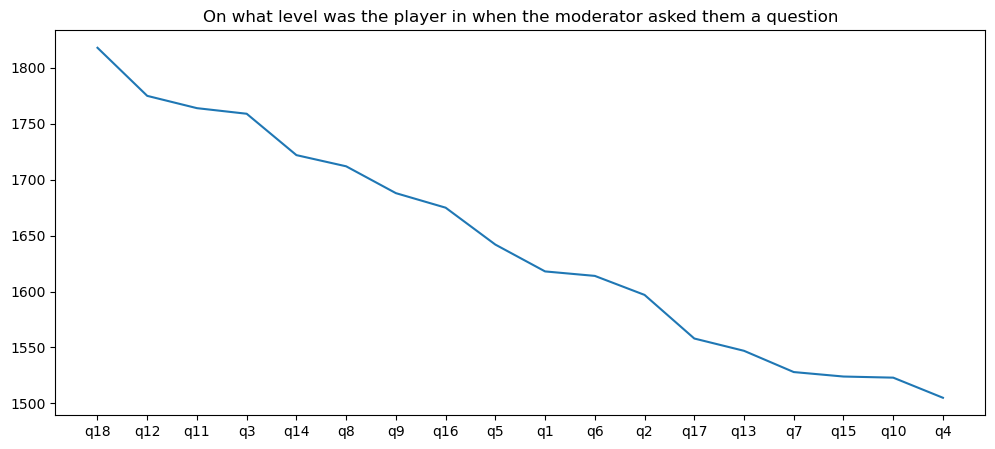

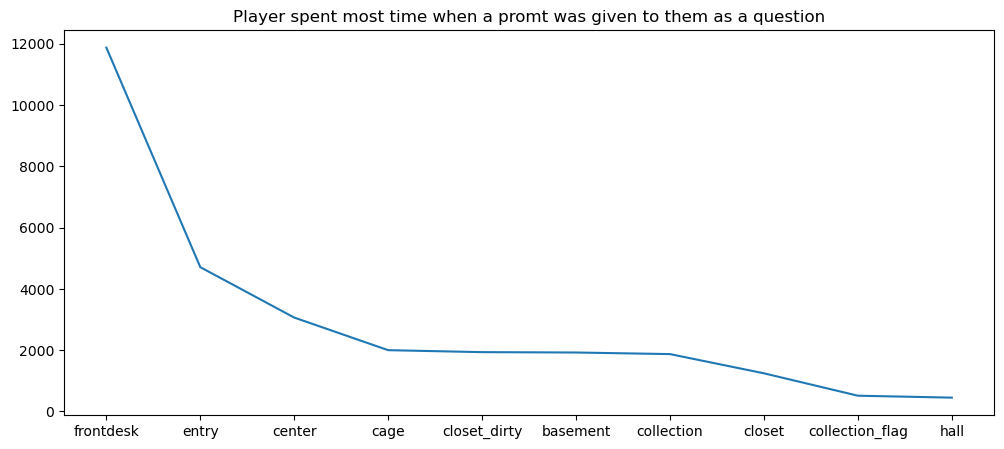

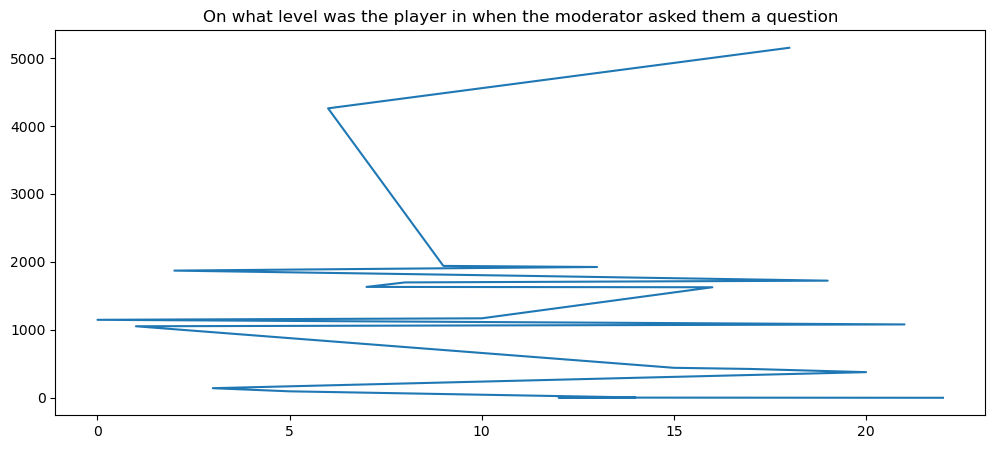

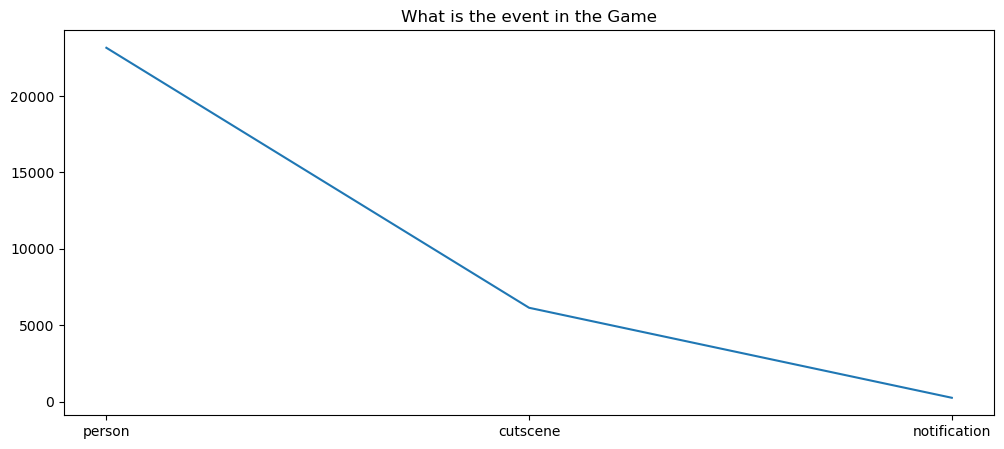

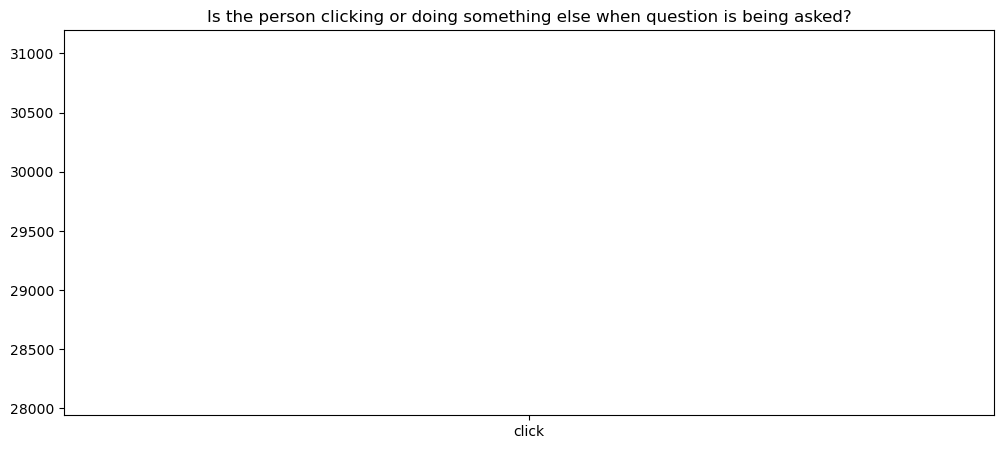

In [19]:
print("Let us understand the unstructured part of the data:")
print('\n')
unStructuredData = textEDA()
a = unStructuredData.prepareQuestionMarkdata()
print("Total number of instances where the moderator needed to ask question from the student:", a.shape[0])
unStructuredData.howMuchTimeelapsed()
unStructuredData.difficultQuestion()
unStructuredData.timeSpentinRoom()
unStructuredData.whichLevel()
unStructuredData.what_eventIntheGame()
unStructuredData.what_playerIsDoing()


# **Text Analysis for all the comments**

Since we have a lot information in unstructure format, I wanted to use graph theory to further analyze and understand the data. Since we are dealing with hige amount of data, we wanted to select features based on following parameters:

1. Where questions were asked 
2. When the event in the game was based on "person_click"
3. When level group was on 5-12
4. When fqid was a worker
5. When text_gqid =  tunic.drycleaner.frontdesk.worker.hub

Following commands were executed to prepare the data:

1. df_train_text['Source_questionMark'] = df_train_text['text'].str.endswith('?')
2. df_questionMark_network=df_train_text.loc[df_train_text['Source_questionMark'] == True]
3. df_questionMark_network_final = df_questionMark_network.loc[df_questionMark_network['event_name'] == 'person_click']
4. df_questionMark_network_final = df_questionMark_network.loc[df_questionMark_network['level_group'] == '5-12']
5. df_questionMark_network_final = df_questionMark_network.loc[df_questionMark_network['fqid'] == 'worker']
6. df_questionMark_network_final = df_questionMark_network.loc[df_questionMark_network['text_fqid'] == 'tunic.drycleaner.frontdesk.worker.hub']

df_questionMark_network_final.shape

In [20]:
def prepareData(df):
    
    
    df[['event_id','event_name_activity']] = df['event_name'].str.split('_',expand = True) 

    df['Source_questionMark'] = df['text'].str.endswith('?')
    df=df.loc[df['Source_questionMark'] == True]
    df = df.loc[df['event_name'] == 'person_click']
    df = df.loc[df['level_group'] == '5-12']
    df = df.loc[df['fqid'] == 'worker']
    df = df.loc[df['text_fqid'] == 'tunic.drycleaner.frontdesk.worker.hub']
    
    df_network = pd.DataFrame({
        "Source": df['event_name_activity'],
        'Target': df['text'],
        'Weight': df['fullscreen']
    })
    return df_network
    
    
        

In [21]:
import networkx as nx

class createGraph:
    
    def __init__(self):
        self.graphData = prepareData(df_train_text)
    
    def createGraphfromData(self):
        # Create an empty directed graph
        G = nx.Graph()
        # Add edges to the graph
        for index, row in self.graphData.iterrows():
            source = row['Source']
            target = row['Target']
            weight = row['Weight']
            G.add_edge(source, target, weight=weight)
        print("Our graph looks like this:")
       
        nx.draw(G, with_labels=True)
        # Visualize the graph
        return G
        
        

class networkTextAnalysis(createGraph):
    
    
    def basicInfo_onGraph(self):
        
        global graph
        
        '''
        nx.info() will tell us the following things:
            1. number of nodes
            2. number of edges
            3. average degree
            
            what is average degree: Average degree is the average number of connections of each node in your network
            '''
        graph = super().createGraphfromData() 
        
        return nx.info(graph)
    
    # Calculate the degree of each node
    def degs(self):
        degree = nx.degree(graph)
        print('degree:',degree)
        print('\n')
        
        # Calculate the degree distribution
        degree_sequence = [d for n, d in nx.degree(graph)]
        degree_counts = nx.degree_histogram(graph)
        print('degree sequence:',degree_sequence)
        print('degree counts:',degree_counts)
        
    
    # Calculate the number of connected components in the graph
    def graphComponents(self):
        
        components = nx.connected_components(graph)
        print('components:',components)
        print('\n')
        return components
    
    # Calculate the average shortest path length between all pairs of nodes
    def shortestPath(self):
        shortest_path_length = nx.average_shortest_path_length(graph)
        # Find all shortest paths
        shortest_paths = dict(nx.all_pairs_shortest_path(graph))

        # Print all shortest paths
        for source, paths in shortest_paths.items():
            for target, path in paths.items():
                print(f"Shortest path from {source} to {target}: {path}")
                
        print('Average distance shortest path: ',shortest_path_length)
        print('\n')
        return shortest_path_length
    
    # Calculate the clustering coefficient of each node
    def clustering_coeff(self):
        clustering_coefficient = nx.clustering(graph)
        print('clustering coeff: ',clustering_coefficient)
        print('\n')
        return clustering_coefficient
    
    # Calculate the betweenness centrality of each node
    def bet_centrality(self):
        betweenness_centrality = nx.betweenness_centrality(graph)
        print('betweenness centrality: ',betweenness_centrality)
        print('\n')
        nx.draw(graph, with_labels=True, node_color=list(betweenness_centrality.values()))
        plt.show()
        return betweenness_centrality
    
    # Calculate the closeness centrality of each node
    def close_centrality(self):
        closeness_centrality = nx.closeness_centrality(graph)
        print('closenness centrality: ',closeness_centrality.items())
        print('\n')
        nx.draw(graph, with_labels=True, node_color=list(closeness_centrality.values()))
        plt.show()
        return closeness_centrality
    
    # Create a dictionary of values and their corresponding graphs
    def plot_values(self):
        degree = self.degs()
        components = self.graphComponents()
        shortest_path_length = self.shortestPath()
        clustering_coefficient = self.clustering_coeff()
        betweenness_centrality = self.bet_centrality()
        closeness_centrality = self.close_centrality
        return degree, components, shortest_path_length, clustering_coefficient, betweenness_centrality, closeness_centrality 
        

The graph that has been formed on the data we have in hand has the following properties:


Our graph looks like this:


'Graph with 8 nodes and 7 edges'

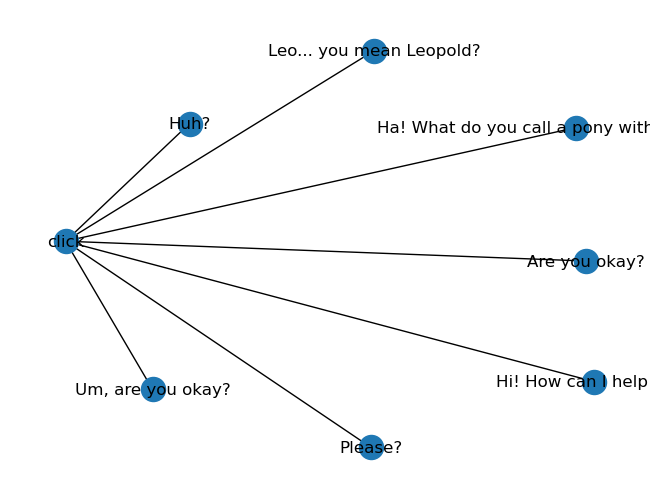

In [22]:
textAnalysis = networkTextAnalysis()
print("The graph that has been formed on the data we have in hand has the following properties:")
print('\n')
textAnalysis.basicInfo_onGraph()

Based on the above "Directed weighted" graph, we can say that:

The click action performed by the student indicates that the moderator is trying to ask some sort of question when they are stuck somewhere or the student is trying to clarify a doubt. Since, the graph has weights based on"Fullscreen", we can assume that when the student is stuck, they try to exit the full screen mode so that they can ask questions from the moderator

In [23]:
print("The degree of the graph is distributed in the following way:")
print('\n')
textAnalysis.degs()

The degree of the graph is distributed in the following way:


degree: [('click', 7), ('Hi! How can I help you?', 1), ('Please?', 1), ('Leo... you mean Leopold?', 1), ('Um, are you okay?', 1), ('Ha! What do you call a pony with a sore throat?', 1), ('Huh?', 1), ('Are you okay?', 1)]


degree sequence: [7, 1, 1, 1, 1, 1, 1, 1]
degree counts: [0, 7, 0, 0, 0, 0, 0, 1]


The above information tells us how important a node is in the graph based on the number of edges coming out of a node. Clearly "Click" is the mode important node

betweenness centrality:  {'click': 1.0, 'Hi! How can I help you?': 0.0, 'Please?': 0.0, 'Leo... you mean Leopold?': 0.0, 'Um, are you okay?': 0.0, 'Ha! What do you call a pony with a sore throat?': 0.0, 'Huh?': 0.0, 'Are you okay?': 0.0}




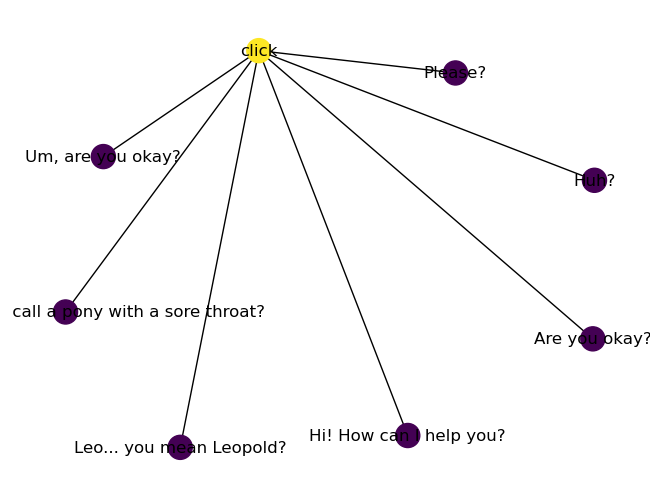

{'click': 1.0,
 'Hi! How can I help you?': 0.0,
 'Please?': 0.0,
 'Leo... you mean Leopold?': 0.0,
 'Um, are you okay?': 0.0,
 'Ha! What do you call a pony with a sore throat?': 0.0,
 'Huh?': 0.0,
 'Are you okay?': 0.0}

In [24]:
textAnalysis.bet_centrality()

closenness centrality:  dict_items([('click', 1.0), ('Hi! How can I help you?', 0.5384615384615384), ('Please?', 0.5384615384615384), ('Leo... you mean Leopold?', 0.5384615384615384), ('Um, are you okay?', 0.5384615384615384), ('Ha! What do you call a pony with a sore throat?', 0.5384615384615384), ('Huh?', 0.5384615384615384), ('Are you okay?', 0.5384615384615384)])




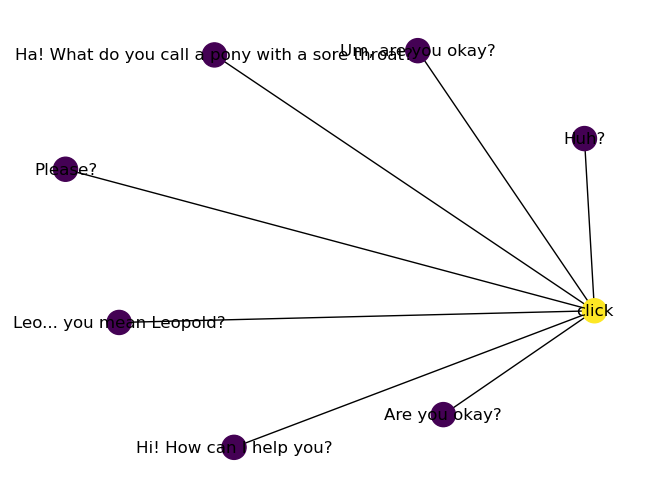

{'click': 1.0,
 'Hi! How can I help you?': 0.5384615384615384,
 'Please?': 0.5384615384615384,
 'Leo... you mean Leopold?': 0.5384615384615384,
 'Um, are you okay?': 0.5384615384615384,
 'Ha! What do you call a pony with a sore throat?': 0.5384615384615384,
 'Huh?': 0.5384615384615384,
 'Are you okay?': 0.5384615384615384}

In [25]:
textAnalysis.close_centrality()

Closeness centrality tells us how fast the flow of information is through a particular node.

In [26]:
textAnalysis.shortestPath()

Shortest path from click to click: ['click']
Shortest path from click to Hi! How can I help you?: ['click', 'Hi! How can I help you?']
Shortest path from click to Please?: ['click', 'Please?']
Shortest path from click to Leo... you mean Leopold?: ['click', 'Leo... you mean Leopold?']
Shortest path from click to Um, are you okay?: ['click', 'Um, are you okay?']
Shortest path from click to Ha! What do you call a pony with a sore throat?: ['click', 'Ha! What do you call a pony with a sore throat?']
Shortest path from click to Huh?: ['click', 'Huh?']
Shortest path from click to Are you okay?: ['click', 'Are you okay?']
Shortest path from Hi! How can I help you? to Hi! How can I help you?: ['Hi! How can I help you?']
Shortest path from Hi! How can I help you? to click: ['Hi! How can I help you?', 'click']
Shortest path from Hi! How can I help you? to Please?: ['Hi! How can I help you?', 'click', 'Please?']
Shortest path from Hi! How can I help you? to Leo... you mean Leopold?: ['Hi! How can

1.75

The average number of steps along the shortest paths for all possible pairs of network nodes in our Graph is 1.75.

The above information tells us the path from a node to all the other paths and the above information tells us how sequence of events happened.

In [27]:
df_train_obj =  trainDataPreparation()

In [28]:
df_train = df_train_obj.merge()

In [29]:
df_train['level_group'].unique()

['0-4', '5-12', '13-22']
Categories (3, object): ['0-4', '13-22', '5-12']

# Predictive modeling

**We are moving ahead with an ensemble technique. This would be a custom enseble machine learning technique.**

We will perform the following tasks:
1. Clustering: KMeans
2. Binary classification: tree based model

# Clustering method

We are applying clustering algorithm to cluster the data that looks similar. based on the above information, we can say that let's cluster the data into two groups since we have three level groups

In [30]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
import numpy as np

class clusters:
    def __init__(self,df):
        self.df = df
        
    def encode(self):
        # One-hot encode the categorical variables
        encoder = OneHotEncoder()
        encoded_data = encoder.fit_transform(self.df)
        return encoded_data
    def clusteringKMeans(self):
        
        newEncodedData = self.encode()
        
        # Apply k-means clustering on the encoded data
        kmeans = KMeans(n_clusters=2, random_state=42)
        clusters = kmeans.fit_predict(newEncodedData)

        # Add cluster labels to the DataFrame
        self.df['cluster_label'] = clusters
        
        return self.df
        

In [31]:
clustered_data = clusters(df_train)
clusteringImplementedData = clustered_data.clusteringKMeans()

In [32]:
clusteringImplementedData['cluster_label'].value_counts()

0    269898
1    154218
Name: cluster_label, dtype: int64

In [33]:
clusteringImplementedData.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,music,level_group,event_id,event_name_activity,Source_questionMark,session_id,correct,Session_ID_labels,question,cluster_label
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,...,1,0-4,cutscene,click,False,20090312431273200_q1,1,20090312431273200,q1,1
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,...,1,0-4,person,click,True,20090312433251036_q1,0,20090312433251036,q1,1
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,...,1,0-4,person,click,False,20090312455206810_q1,1,20090312455206810,q1,1
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,...,1,0-4,person,click,False,20090313091715820_q1,0,20090313091715820,q1,1
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,...,1,0-4,person,click,True,20090313571836404_q1,1,20090313571836404,q1,1


In [34]:
clusteringImplementedData_clusterOne = clusteringImplementedData.loc[clusteringImplementedData['cluster_label'] == 0]

In [35]:
clusteringImplementedData_clusterOne.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,music,level_group,event_id,event_name_activity,Source_questionMark,session_id,correct,Session_ID_labels,question,cluster_label
10,20090312431273200,10,9133,navigate_click,undefined,0,NaN,501.110046,-160.748169,605.0,...,1,0-4,navigate,click,NaN,20090315081004164_q1,0,20090315081004164,q1,0
12,20090312431273200,12,12030,navigate_click,undefined,0,NaN,510.081482,-106.352097,614.0,...,1,0-4,navigate,click,NaN,20090315101457836_q1,1,20090315101457836,q1,0
14,20090312431273200,14,14814,navigate_click,undefined,0,NaN,273.991425,-196.802368,406.0,...,1,0-4,navigate,click,NaN,20090315270479452_q1,0,20090315270479452,q1,0
15,20090312431273200,15,15498,navigate_click,undefined,0,NaN,185.708466,-205.806534,363.0,...,1,0-4,navigate,click,NaN,20090316152177500_q1,1,20090316152177500,q1,0
16,20090312431273200,16,16046,navigate_click,undefined,0,NaN,0.583565,-225.691299,234.0,...,1,0-4,navigate,click,NaN,20090316190523732_q1,1,20090316190523732,q1,0


In [36]:
print("Total number of level present in first cluster:")
print(clusteringImplementedData_clusterOne['level_group'].value_counts())
print('\n')
print("Events that dominated in the first cluster looks similar:")
print(clusteringImplementedData_clusterOne['event_name'].value_counts())
print('\n')
print('Questions which had similar number of outcome in terms of student performance are:')
clusteringImplementedData_clusterOne['question'].value_counts()

Total number of level present in first cluster:
13-22    140350
5-12      91210
0-4       38338
Name: level_group, dtype: int64


Events that dominated in the first cluster looks similar:
navigate_click        179177
object_click           35890
object_hover           19099
map_hover              17316
notebook_click          8712
map_click               8555
checkpoint              1149
cutscene_click             0
notification_click         0
observation_click          0
person_click               0
Name: event_name, dtype: int64


Questions which had similar number of outcome in terms of student performance are:


q4     15689
q15    15656
q10    15523
q7     15477
q13    15447
q17    15365
q2     15316
q1     15222
q6     15098
q5     14947
q9     14848
q8     14752
q16    14711
q14    14525
q11    14508
q3     14443
q12    14315
q18    14056
Name: question, dtype: int64

In [37]:
clusteringImplementedData_clusterOne = clusteringImplementedData.loc[clusteringImplementedData['cluster_label'] == 1]
print("Total number of level present in second cluster:")
print(clusteringImplementedData_clusterOne['level_group'].value_counts())
print('\n')
print("Events that dominated in the second cluster looks similar:")
print(clusteringImplementedData_clusterOne['event_name'].value_counts())
print('\n')
print('Questions which had similar number of outcome in terms of student performance are:')
clusteringImplementedData_clusterOne['question'].value_counts()

Total number of level present in second cluster:
13-22    77632
5-12     52799
0-4      23787
Name: level_group, dtype: int64


Events that dominated in the second cluster looks similar:
person_click          97449
cutscene_click        42884
notification_click    10328
observation_click      3557
checkpoint                0
map_click                 0
map_hover                 0
navigate_click            0
notebook_click            0
object_click              0
object_hover              0
Name: event_name, dtype: int64


Questions which had similar number of outcome in terms of student performance are:


q18    9506
q12    9247
q3     9119
q11    9054
q14    9037
q16    8851
q8     8810
q9     8714
q5     8615
q6     8464
q1     8340
q2     8246
q17    8197
q13    8115
q7     8085
q10    8039
q15    7906
q4     7873
Name: question, dtype: int64

# Classification

In [38]:
# # Rename the duplicate column
# clusteringImplementedData = clusteringImplementedData.rename(columns={'session_id': 'session_id_1'})


In [39]:
clusteringImplementedData.columns

Index(['session_id', 'index', 'elapsed_time', 'event_name', 'name', 'level',
       'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
       'hover_duration', 'text', 'fqid', 'room_fqid', 'text_fqid',
       'fullscreen', 'hq', 'music', 'level_group', 'event_id',
       'event_name_activity', 'Source_questionMark', 'session_id', 'correct',
       'Session_ID_labels', 'question', 'cluster_label'],
      dtype='object')

In [40]:
clusteringImplementedData.columns = ['session_id', 'index', 'elapsed_time', 'event_name', 'name', 'level',
       'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
       'hover_duration', 'text', 'fqid', 'room_fqid', 'text_fqid',
       'fullscreen', 'hq', 'music', 'level_group', 'event_id',
       'event_name_activity', 'Source_questionMark', 'session_id_1_to_remove', 'correct',
       'Session_ID_labels', 'question', 'cluster_label']

In [41]:
clusteringImplementedData = clusteringImplementedData.drop('session_id_1_to_remove', axis=1)

In [42]:
clusteringImplementedData.dtypes

session_id                int64
index                     int64
elapsed_time              int32
event_name             category
name                   category
level                     uint8
page                    float64
room_coor_x             float32
room_coor_y             float32
screen_coor_x           float32
screen_coor_y           float32
hover_duration          float32
text                   category
fqid                   category
room_fqid              category
text_fqid              category
fullscreen             category
hq                     category
music                  category
level_group            category
event_id                 object
event_name_activity      object
Source_questionMark      object
correct                   int64
Session_ID_labels        object
question                 object
cluster_label             int32
dtype: object

In [43]:
clusteringImplementedData.shape

(424116, 27)

In [44]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_decision_forests as tfdf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [45]:
df_train_labels['session'] = df_train_labels.session_id.apply(lambda x: int(x.split('_')[0]) )
df_train_labels['q'] = df_train_labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

In [46]:
df_train_labels

,session_id,correct,Session_ID_labels,question,session,q
0,20090312431273200_q1,1,20090312431273200,q1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,q1,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,q1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,q1,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,q1,20090313571836404,1
...,...,...,...,...,...,...
424111,22100215342220508_q18,1,22100215342220508,q18,22100215342220508,18
424112,22100215460321130_q18,1,22100215460321130,q18,22100215460321130,18
424113,22100217104993650_q18,1,22100217104993650,q18,22100217104993650,18
424114,22100219442786200_q18,1,22100219442786200,q18,22100219442786200,18


In [47]:
CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

In [48]:
def feature_engineer(dataset_df):
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df

In [49]:
dataset_df = feature_engineer(clusteringImplementedData)
print("Full prepared dataset shape is {}".format(clusteringImplementedData.shape))

Full prepared dataset shape is (424116, 27)


In [50]:
dataset_df.head()

,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.0,7.701275,...,383.044861,0.039825,49246.539458,1.230975,-1.000000,399.296038,129.292411,214.871000,104.082743,0.053790
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.0,-130.347168,...,379.301025,0.014999,126666.129584,2.358652,-1.000000,622.061374,230.370874,240.280218,99.067861,0.021751
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.0,14.306062,...,378.784912,0.016156,80175.676658,2.096919,-1.000000,357.227701,137.409476,203.268560,120.255453,0.021940
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.0,-84.045959,...,370.723083,0.022979,67372.714092,1.232616,0.000000,445.980041,156.186242,252.554707,121.062929,0.035248
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.1,-30.762283,...,387.930084,0.012006,777382.529186,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,0.033178


In [51]:
def split_dataset(dataset, test_ratio=0.20):
    USER_LIST = dataset.index.unique()
    split = int(len(USER_LIST) * (1 - 0.20))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]]

train_x, valid_x = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_x), len(valid_x)))

909 examples in training, 228 examples in testing.


In [52]:
rf = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmpmtl8p568 as temporary training directory


In [53]:
# Fetch the unique list of user sessions in the validation dataset. We assigned 
# `session_id` as the index of our feature engineered dataset. Hence fetching 
# the unique values in the index column will give us a list of users in the 
# validation set.
VALID_USER_LIST = valid_x.index.unique()

# Create a dataframe for storing the predictions of each question for all users
# in the validation set.
# For this, the required size of the data frame is: 
# (no: of users in validation set  x no of questions).
# We will initialize all the predicted values in the data frame to zero.
# The dataframe's index column is the user `session_id`s. 
prediction_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)

# Create an empty dictionary to store the models created for each question.
models = {}

# Create an empty dictionary to store the evaluation score for each question.
evaluation_dict ={}

In [54]:
# Iterate through questions 1 to 18 to train models for each question, evaluate
# the trained model and store the predicted values.
for q_no in range(1,19):

    # Select level group for the question based on the q_no.
    if q_no<=3: grp = '0-4'
    elif q_no<=13: grp = '5-12'
    elif q_no<=22: grp = '13-22'
    print("### q_no", q_no, "grp", grp)
    
        
    # Filter the rows in the datasets based on the selected level group. 
    train_df = train_x.loc[train_x.level_group == grp]
    train_users = train_df.index.values
    valid_df = valid_x.loc[valid_x.level_group == grp]
    valid_users = valid_df.index.values

    # Select the labels for the related q_no.
    train_labels = df_train_labels.loc[df_train_labels.q==q_no].set_index('session').loc[train_users]
    valid_labels = df_train_labels.loc[df_train_labels.q==q_no].set_index('session').loc[valid_users]

    # Add the label to the filtered datasets.
    train_df["correct"] = train_labels["correct"]
    valid_df["correct"] = valid_labels["correct"]

    # There's one more step required before we can train the model. 
    # We need to convert the datatset from Pandas format (pd.DataFrame)
    # into TensorFlow Datasets format (tf.data.Dataset).
    # TensorFlow Datasets is a high performance data loading library 
    # which is helpful when training neural networks with accelerators like GPUs and TPUs.
    # We are omitting `level_group`, since it is not needed for training anymore.
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df.loc[:, train_df.columns != 'level_group'], label="correct")
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df.loc[:, valid_df.columns != 'level_group'], label="correct")

    # We will now create the Gradient Boosted Trees Model with default settings. 
    # By default the model is set to train for a classification task.
    gbtm = tfdf.keras.GradientBoostedTreesModel(verbose=0)
    gbtm.compile(metrics=["accuracy"])

    # Train the model.
    gbtm.fit(x=train_ds)

    # Store the model
    models[f'{grp}_{q_no}'] = gbtm

    # Evaluate the trained model on the validation dataset and store the 
    # evaluation accuracy in the `evaluation_dict`.
    inspector = gbtm.make_inspector()
    inspector.evaluation()
    evaluation = gbtm.evaluate(x=valid_ds,return_dict=True)
    evaluation_dict[q_no] = evaluation["accuracy"]         

    # Use the trained model to make predictions on the validation dataset and 
    # store the predicted values in the `prediction_df` dataframe.
    predict = gbtm.predict(x=valid_ds)
    prediction_df.loc[valid_users, q_no-1] = predict.flatten()   

### q_no 1 grp 0-4


[INFO 2023-06-06T18:53:52.796005138+00:00 kernel.cc:1214] Loading model from path /tmp/tmp0avxrzu1/model/ with prefix 29da735d9de34ff7
[INFO 2023-06-06T18:53:52.800981994+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2023-06-06T18:53:52.801407802+00:00 kernel.cc:1046] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 64ms/step
### q_no 2 grp 0-4


[INFO 2023-06-06T18:53:59.81575149+00:00 kernel.cc:1214] Loading model from path /tmp/tmpu594p5ga/model/ with prefix 00359556b2484be8
[INFO 2023-06-06T18:53:59.837039538+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 62ms/step
### q_no 3 grp 0-4


[INFO 2023-06-06T18:54:01.141758524+00:00 kernel.cc:1214] Loading model from path /tmp/tmpi7nc5sig/model/ with prefix 979e1ebb82364c07
[INFO 2023-06-06T18:54:01.143361755+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 63ms/step
### q_no 4 grp 5-12


[INFO 2023-06-06T18:54:02.40636965+00:00 kernel.cc:1214] Loading model from path /tmp/tmpj5qhbetj/model/ with prefix cdc17899864a493f
[INFO 2023-06-06T18:54:02.409038504+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 63ms/step
### q_no 5 grp 5-12


[INFO 2023-06-06T18:54:03.894550477+00:00 kernel.cc:1214] Loading model from path /tmp/tmpz3chimf4/model/ with prefix 7abe3f846f0b4944
[INFO 2023-06-06T18:54:03.897914035+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2023-06-06T18:54:03.897962803+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 70ms/step
### q_no 6 grp 5-12


[INFO 2023-06-06T18:54:05.27802792+00:00 kernel.cc:1214] Loading model from path /tmp/tmptntkk6rx/model/ with prefix d03e540d554b46d7
[INFO 2023-06-06T18:54:05.280630839+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 63ms/step
### q_no 7 grp 5-12


[INFO 2023-06-06T18:54:06.522946086+00:00 kernel.cc:1214] Loading model from path /tmp/tmpk_94j0bj/model/ with prefix 0b4d7f72132940fb
[INFO 2023-06-06T18:54:06.524873382+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 62ms/step
### q_no 8 grp 5-12


[INFO 2023-06-06T18:54:07.793855557+00:00 kernel.cc:1214] Loading model from path /tmp/tmp6v6bgmvr/model/ with prefix fb2603f7da8f4d34
[INFO 2023-06-06T18:54:07.796400821+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 66ms/step
### q_no 9 grp 5-12


[INFO 2023-06-06T18:54:09.06615265+00:00 kernel.cc:1214] Loading model from path /tmp/tmp210uxyab/model/ with prefix 8970fa878d494931
[INFO 2023-06-06T18:54:09.06870155+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 60ms/step
### q_no 10 grp 5-12


[INFO 2023-06-06T18:54:10.4841346+00:00 kernel.cc:1214] Loading model from path /tmp/tmpp3c71vz9/model/ with prefix 22edecc4aa194f94
[INFO 2023-06-06T18:54:10.48624154+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 64ms/step
### q_no 11 grp 5-12


[INFO 2023-06-06T18:54:11.974636162+00:00 kernel.cc:1214] Loading model from path /tmp/tmpmn71kycv/model/ with prefix ea4b0289c14f4c26
[INFO 2023-06-06T18:54:11.978289931+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 63ms/step
### q_no 12 grp 5-12


[INFO 2023-06-06T18:54:13.371584235+00:00 kernel.cc:1214] Loading model from path /tmp/tmpp25e2ls2/model/ with prefix 32235e8f75924288
[INFO 2023-06-06T18:54:13.374563632+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 62ms/step
### q_no 13 grp 5-12


[INFO 2023-06-06T18:54:14.755665874+00:00 kernel.cc:1214] Loading model from path /tmp/tmppjmv68wh/model/ with prefix 39d1f95d53454342
[INFO 2023-06-06T18:54:14.758010791+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2023-06-06T18:54:14.758052696+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 65ms/step
### q_no 14 grp 13-22


[INFO 2023-06-06T18:54:16.190832819+00:00 kernel.cc:1214] Loading model from path /tmp/tmprs128u15/model/ with prefix f303e3fd38ba4b80
[INFO 2023-06-06T18:54:16.19393023+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 64ms/step
### q_no 15 grp 13-22


[INFO 2023-06-06T18:54:17.812600181+00:00 kernel.cc:1214] Loading model from path /tmp/tmpr3g2pk6t/model/ with prefix 2135731ab0404dbf
[INFO 2023-06-06T18:54:17.815406334+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 64ms/step
### q_no 16 grp 13-22


[INFO 2023-06-06T18:54:19.082268725+00:00 kernel.cc:1214] Loading model from path /tmp/tmp_h9x3lhe/model/ with prefix 2f1cd30aa66b4977
[INFO 2023-06-06T18:54:19.084285172+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 66ms/step
### q_no 17 grp 13-22


[INFO 2023-06-06T18:54:20.561899392+00:00 kernel.cc:1214] Loading model from path /tmp/tmpoc9rrq2q/model/ with prefix aeec1d8adb494206
[INFO 2023-06-06T18:54:20.564857195+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 65ms/step
### q_no 18 grp 13-22


[INFO 2023-06-06T18:54:21.988548812+00:00 kernel.cc:1214] Loading model from path /tmp/tmpeuuaad5s/model/ with prefix 6b79a869718349ac
[INFO 2023-06-06T18:54:21.990525282+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 63ms/step


In [55]:
for name, value in evaluation_dict.items():
  print(f"question {name}: accuracy {value:.4f}")

print("\nAverage accuracy", sum(evaluation_dict.values())/18)

question 1: accuracy 0.6711
question 2: accuracy 1.0000
question 3: accuracy 0.9474
question 4: accuracy 0.8684
question 5: accuracy 0.5921
question 6: accuracy 0.7632
question 7: accuracy 0.7105
question 8: accuracy 0.6053
question 9: accuracy 0.6447
question 10: accuracy 0.5789
question 11: accuracy 0.5526
question 12: accuracy 0.9079
question 13: accuracy 0.8026
question 14: accuracy 0.6974
question 15: accuracy 0.6184
question 16: accuracy 0.7105
question 17: accuracy 0.5789
question 18: accuracy 0.9737

Average accuracy 0.734649121761322


In [56]:
tfdf.model_plotter.plot_model_in_colab(models['0-4_1'], tree_idx=0, max_depth=3)

In [57]:
# Create a dataframe of required size:
# (no: of users in validation set x no: of questions) initialized to zero values
# to store true values of the label `correct`. 
true_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)
for i in range(18):
    # Get the true labels.
    tmp = df_train_labels.loc[df_train_labels.q == i+1].set_index('session').loc[VALID_USER_LIST]
    true_df[i] = tmp.correct.values

max_score = 0; best_threshold = 0

# Loop through threshold values from 0.4 to 0.8 and select the threshold with 
# the highest `F1 score`.
for threshold in np.arange(0.4,0.8,0.01):
    metric = tfa.metrics.F1Score(num_classes=2,average="macro",threshold=threshold)
    y_true = tf.one_hot(true_df.values.reshape((-1)), depth=2)
    y_pred = tf.one_hot((prediction_df.values.reshape((-1))>threshold).astype('int'), depth=2)
    metric.update_state(y_true, y_pred)
    f1_score = metric.result().numpy()
    if f1_score > max_score:
        max_score = f1_score
        best_threshold = threshold
        
print("Best threshold ", best_threshold, "\tF1 score ", max_score)

Best threshold  0.4900000000000001 	F1 score  0.6359889


In [58]:
# Reference
# https://www.kaggle.com/code/philculliton/basic-submission-demo
# https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664/notebook


import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()



In [59]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (test, sample_submission) in iter_test:
    test_df = feature_engineer(test)
    grp = test_df.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        gbtm = models[f'{grp}_{t}']
        test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df.loc[:, test_df.columns != 'level_group'])
        predictions = gbtm.predict(test_ds)
        mask = sample_submission.session_id.str.contains(f'q{t}')
        n_predictions = (predictions > best_threshold).astype(int)
        sample_submission.loc[mask,'correct'] = n_predictions.flatten()
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
1/1 [==============================] - 0s 73ms/step


In [60]:
! head submission.csv

session_id,correct
20090109393214576_q1,1
20090109393214576_q2,1
20090109393214576_q3,1
20090109393214576_q4,1
20090109393214576_q5,1
20090109393214576_q6,1
20090109393214576_q7,1
20090109393214576_q8,0
20090109393214576_q9,1
